In [3]:
# Importation des modules necessaires
import sys
sys.path.insert(0,'../')
import argopy
import xarray as xr
import glob
import numpy as np
from m_argo_data import read_argo_data_for_NCEP
from m_NCEP_data import *
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [4]:
#
# Init.
#
num_float = '6902802'
rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
rep_NCEP_data= '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/NCEP/'

which_psal = 1
code_inair = [699,711,799]
code_inwater = [690,710]

In [5]:
# Lecture donnees ARGO
dsair,dsinwater,optode_height,launch_date = read_argo_data_for_NCEP(num_float,rep_data_argo,which_psal,code_inair,code_inwater)

In [6]:
# Chargement des donnees NCEP si besoin
ftp_server = 'ftp.cdc.noaa.gov'
rep_ftp = 'Datasets/ncep.reanalysis/surface'
rep_local = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
ncep_variables = ['slp','air.sig995','rhum.sig995']

In [7]:
download_NCEP(dsair['JULD'],ftp_server,rep_ftp,rep_local,ncep_variables)

Telechargement des donnees NCEP si besoin
File slp.2018.nc already exists.
File air.sig995.2018.nc already exists.
File rhum.sig995.2018.nc already exists.
File slp.2019.nc already exists.
File air.sig995.2019.nc already exists.
File rhum.sig995.2019.nc already exists.
File slp.2020.nc already exists.
File air.sig995.2020.nc already exists.
File rhum.sig995.2020.nc already exists.
File slp.2021.nc already exists.
File air.sig995.2021.nc already exists.
File rhum.sig995.2021.nc already exists.
File slp.2022.nc already exists.
File air.sig995.2022.nc already exists.
File rhum.sig995.2022.nc already exists.


In [8]:
# Lecture donnees NCEP et interpolation sur date/position ARGO des donnees InAir.
# Les donnees Inwater sont faites legerement avant les donnees InAir.
ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum = read_NCEP(rep_NCEP_data,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])


In [18]:
# Calcul de PPOX_NCEP
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum,optode_height,z0q)

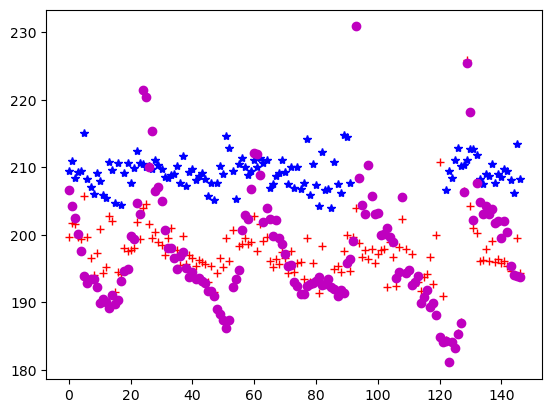

In [19]:
# Trace
plt.figure()
plt.plot(NCEP_PPOX,'*b')
plt.plot(dsair['PPOX_DOXY'],'r+')
plt.plot(dsinwater['PPOX_DOXY'],'om')

In [20]:
# Calcul de la solution avec un simple gain sans et avec Carry_Over
###################################################################
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
valid_index = np.isfinite(NCEP_PPOX)
PPOX1 = PPOX1[valid_index]
PPOX2 = PPOX2[valid_index]
NCEP_PPOX = NCEP_PPOX[valid_index]
delta_T = (dsair['JULD'].values - launch_date)
delta_T = delta_T.astype(float)
delta_T = delta_T/1e9/86400 # Difference en jour
delta_T = delta_T[valid_index]
print(PPOX1.size,PPOX2.size,delta_T.size)

117 117 117


In [21]:
# Calcul Gain sans CarryOver
def model_Gain(X,G):
    return G * X 
    
initial_guess = 1  # Valeurs initiales pour G 
params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess)
Gain = params_Gain

In [22]:
# Calcul Gain avec CarryOver
def model_Gain_CarryOver(X,G,C):
    return G / (1-C) * (X - C * PPOX2) # C : Carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_CarryOver, covariance = curve_fit(model_Gain_CarryOver, PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_CarryOver,C_estime = params_Gain_CarryOver

[1.06150129]
1.0616854507038496
1.0626105779781014
1.0624834192310089


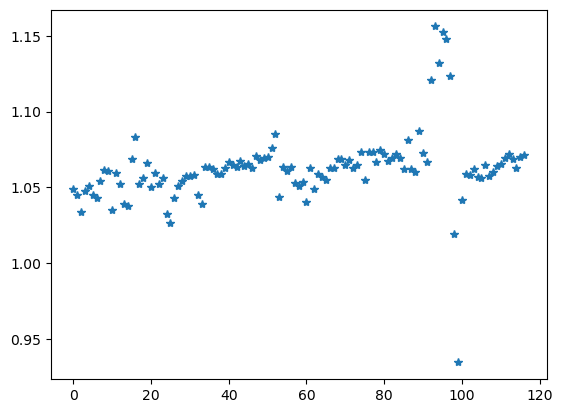

In [23]:
print(Gain)
print(Gain_CarryOver)
print(np.mean(NCEP_PPOX/PPOX1))
print(np.median(NCEP_PPOX/PPOX1))
plt.figure()
plt.plot(NCEP_PPOX/PPOX1,'*')
plt.show()

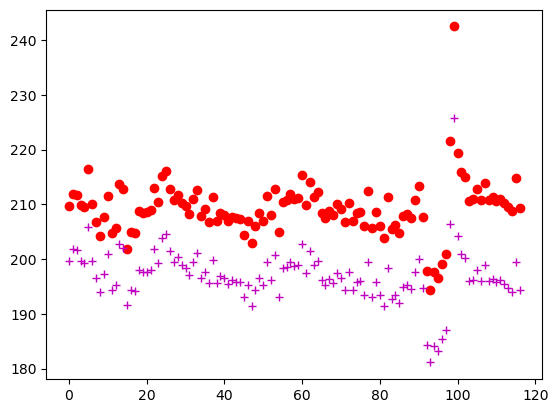

test [1.72152658e-05 1.04967266e+00]
test [0.99902728]
[1.04967266 0.59862205]
1.0496726566416554 0.5986220548359624


In [67]:
# Calcul de la derive comme Locodox
#
degre_poly = 1
Derive_Locodox1 = np.polyfit(delta_T,NCEP_PPOX/PPOX1,degre_poly)
plt.figure()
plt.plot(np.polyval(Derive_Locodox1,delta_T)*PPOX1,'*b')
#Derive_Locodox1[1]=0
plt.plot(np.polyval(Derive_Locodox1,delta_T)*PPOX1,'or')
plt.plot(PPOX1,'+m')

plt.show()
print(f'test {Derive_Locodox1}')



# Sans CarryOver
def model_Gain_Derive_Locodox(X,G):
    return X * G
    
initial_guess = 1
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox, np.polyval(Derive_Locodox1,delta_T)*PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_Locodox1 = params_Locodox
print(f'test {Gain_Locodox1}')

# On en deduit D associe a la formule G * (1 + D / 100 * delta_T/365) * PPOX1 
def model_Locodox(delta_T, G, D):
    return  (1 + D / 100 * delta_T/365) * G * PPOX1 # Sans carry-over

initial_guess = [1, 0]  # Valeurs initiales pour G et D
#params_Locodox, covariance = curve_fit(model_Locodox, delta_T, Gain_Locodox1*np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
params_Locodox, covariance = curve_fit(model_Locodox, delta_T, np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)
print(params_Locodox)
print(Derive_Locodox1[1],Derive_Locodox1[0]*100*365/Derive_Locodox1[1])
#Gain_Locodox, Derive_Locodox = params_Locodox
Gain_Locodox = Gain_Locodox1 * Derive_Locodox1[1]
Derive_Locodox = (Gain_Locodox1 * Derive_Locodox1[0])*100*365/Gain_Locodox

In [61]:
print(Gain_Locodox,Derive_Locodox)
print(params_Locodox)

1.0496726566416554 0.5986220548359624
[1.04967266 0.59862205]


In [62]:
# Avec CarryOver
def model_Gain_Derive_Locodox_CarryOver(X,G,C):
    return G / (1-C) * (X - C * PPOX2) # C : Carry-over

initial_guess = [1,0]
params_Locodox, covariance = curve_fit(model_Gain_Derive_Locodox_CarryOver, np.polyval(Derive_Locodox1,delta_T)*PPOX1, NCEP_PPOX, p0=initial_guess)
Gain_Locodox_CarryOver1, C_estime = params_Locodox

def model_Locodox2(delta_T,G,D,C):
    return (G/(1-C) * (1 + D / 100 * delta_T/365) * (PPOX1 - C * PPOX2) )

def model_Locodox3(X,G,D,C):
    return (G/(1-C) * (1 + D / 100 * delta_T/365) * (X - C * PPOX2) )
    
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D
#params_Locodox_CarryOver, covariance = curve_fit(model_Locodox2, delta_T, Gain_Locodox_CarryOver1*np.polyval(Derive_Locodox1,delta_T)*PPOX1, p0=initial_guess)  
#params_Locodox_CarryOver, covariance = curve_fit(model_Locodox3, Gain_Locodox_CarryOver1*np.polyval(Derive_LOCODOX1,delta_T)*PPOX1, Gain_Locodox_CarryOver1*np.polyval(Derive_LOCODOX1,delta_T)*PPOX1,p0=initial_guess)  

Gain_Locodox_CarryOver = Gain_Locodox_CarryOver1 * Derive_Locodox1[1]
Derive_Locodox = (Gain_Locodox_CarryOver1 * Derive_Locodox1[0])*100*365/Gain_Locodox_CarryOver
print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)
print(Gain_Locodox_CarryOver,Derive_Locodox_CarryOver)
print(Gain_Derive_CarryOver,Derive_CarryOver)

1.0496726566416554 0.5986220548359625
1.0505639032423415 0.5089268028783481
1.0391323716497536 0.5986220560177155
1.0491167424077168 0.5904557336542134


In [64]:
print(Gain_Locodox,Derive_Locodox)
print(Gain_Derive,Derive)
print(Gain_Locodox_CarryOver,Derive_Locodox_CarryOver)
print(Gain_Derive_CarryOver,Derive_CarryOver)

1.0496726566416554 0.5986220548359625
1.0505639032423415 0.5089268028783481
1.0391323716497536 0.5986220560177155
1.0491167424077168 0.5904557336542134


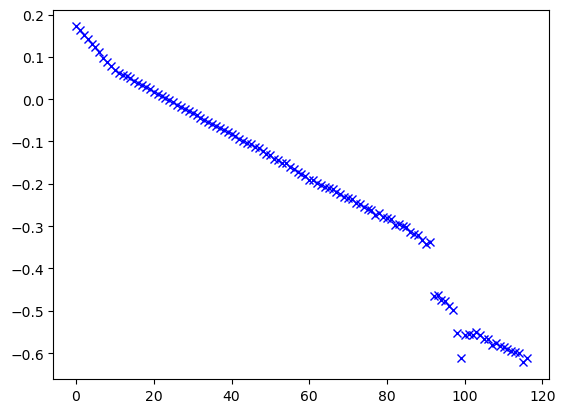

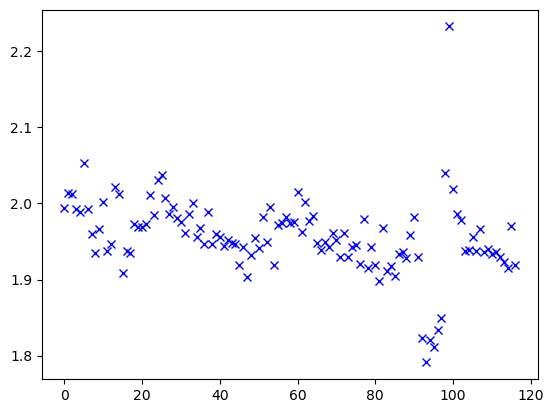

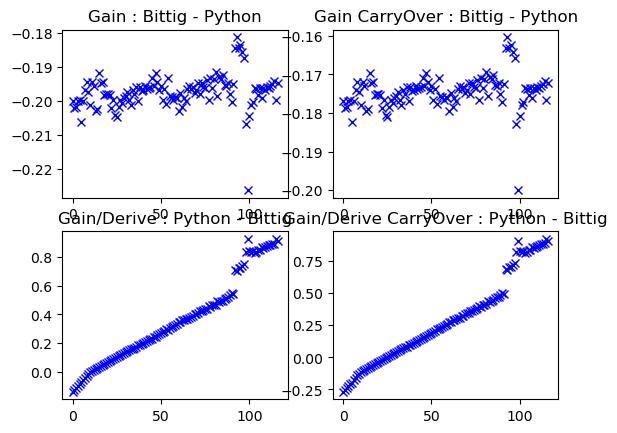

201.78134155273438
212.0791672563681
212.2053685480709
211.80221995388592
212.05639065268062


In [65]:
Gain_Derive_bittig = 1.0513
Derive_bittig = 0.389
Gain_Derive_bittig_CarryOver = 1.0505
Derive_bittig_CarryOver = 0.456
Gain_bittig = 1.0605
Gain_bittig_CarryOver = 1.0608
plt.figure()
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Locodox * (1 + Derive_Locodox / 100 * delta_T/365) * PPOX1,'xb')
plt.figure()
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Locodox_CarryOver * (1 + Derive_Locodox_CarryOver / 100 * delta_T/365) * PPOX1,'xb')

plt.figure()
plt.subplot(2,2,1)
plt.plot(Gain_bittig *  PPOX1 - Gain * PPOX1,'xb')
plt.title('Gain : Bittig - Python')
plt.subplot(2,2,2)
plt.plot(Gain_bittig_CarryOver *  PPOX1 - Gain_CarryOver * PPOX1,'xb')
plt.title('Gain CarryOver : Bittig - Python')
plt.subplot(2,2,3)
plt.plot(Gain_Derive * (1 + Derive / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive : Python - Bittig')
plt.subplot(2,2,4)
plt.plot(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T/365) * PPOX1 - Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T/365) * PPOX1,'xb')
plt.title('Gain/Derive CarryOver : Python - Bittig')
plt.show()

print(PPOX1[1])
print(Gain_Derive * (1 + Derive / 100 * delta_T[1]/365) * PPOX1[1])
print(Gain_Derive_bittig * (1 + Derive_bittig / 100 * delta_T[1]/365) * PPOX1[1])
print(Gain_Derive_CarryOver * (1 + Derive_CarryOver / 100 * delta_T[1]/365) * PPOX1[1])
print(Gain_Derive_bittig_CarryOver * (1 + Derive_bittig_CarryOver / 100 * delta_T[1]/365) * PPOX1[1])


In [14]:
ds_argo_Rtraj_inair

<xarray.Dataset>
Dimensions:                              (N_MEASUREMENT: 1470, N_PARAM: 8,
                                          N_CYCLE: 159, N_CALIB_PARAM: 1,
                                          N_CALIB_JULD: 1, N_HISTORY: 3)
Coordinates:
    LATITUDE                             (N_MEASUREMENT) float64 59.24 ... 65.1
    LONGITUDE                            (N_MEASUREMENT) float64 -39.62 ... -...
Dimensions without coordinates: N_MEASUREMENT, N_PARAM, N_CYCLE, N_CALIB_PARAM,
                                N_CALIB_JULD, N_HISTORY
Data variables: (12/127)
    DATA_TYPE                            (N_MEASUREMENT) object 'Argo traject...
    FORMAT_VERSION                       (N_MEASUREMENT) object '3.2 ' ... '3...
    HANDBOOK_VERSION                     (N_MEASUREMENT) object '1.2 ' ... '1...
    REFERENCE_DATE_TIME                  (N_MEASUREMENT) datetime64[ns] 1950-...
    DATE_CREATION                        (N_MEASUREMENT) datetime64[ns] 2023-...
    DATE_UPDATE                          (N_MEASUREMENT) datetime64[ns] 2023-...
    ...                                   ...
    HISTORY_PARAMETER                    (N_MEASUREMENT, N_HISTORY) object ' ...
    HISTORY_PREVIOUS_VALUE               (N_MEASUREMENT, N_HISTORY) float32 n...
    HISTORY_INDEX_DIMENSION              (N_MEASUREMENT, N_HISTORY) object 'n...
    HISTORY_START_INDEX                  (N_MEASUREMENT, N_HISTORY) float64 n...
    HISTORY_STOP_INDEX                   (N_MEASUREMENT, N_HISTORY) float64 n...
    HISTORY_QCTEST                       (N_MEASUREMENT, N_HISTORY) object ' ...
Attributes:
    title:                        Argo float trajectory file
    institution:                  CORIOLIS
    source:                       Argo float
    history:                      2023-06-14T18:41:35Z creation; 2023-06-14T1...
    references:                   http://www.argodatamgt.org/Documentation
    user_manual_version:          3.4
    Conventions:                  Argo-3.2 CF-1.6
    featureType:                  trajectory
    decoder_version:              CODA_055r
    comment_on_resolution:        JULD and PRES variable resolutions depend o...
    comment_on_measurement_code:  Meaning of some specific measurement codes ...

In [45]:
data = {
    "CYCLE_NUMBER": ("N_CYCLE", cycle_results.values),
    "PSAL": ("N_CYCLE", psal_results.values),  # 4 cycles différents
}
merdum = xr.Dataset(data)
aligned_ds1 = merdum.reindex(N_CYCLE=toto['CYCLE_NUMBER'], method=None)

# Remplir PSAL de ds2 avec les valeurs de PSAL correspondantes de ds1
toto['PSAL'] = aligned_ds1['PSAL']
print(toto['PSAL'])

ValueError: Indexer has dimensions ('CYCLE_NUMBER',) that are different from that to be indexed along 'N_CYCLE'

In [41]:
#print(toto2['PSAL'].values)
#print(psal_results.values)

data = {
    "CYCLE_NUMBER": ("N_CYCLE", cycle_results.values),
    "PSAL": ("N_CYCLE", psal_results.values),  # 4 cycles différents
}
merdum = xr.Dataset(data)
toto['PSAL'][:]=np.nan
toto['PSAL'] = toto['PSAL'].where(~toto['CYCLE_NUMBER'].isin(merdum['CYCLE_NUMBER']), merdum['PSAL'])


In [43]:
print(toto['PSAL'])


<xarray.DataArray 'PSAL' (CYCLE_NUMBER: 148, N_CYCLE: 159)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, 34.78900146, 34.81299973, ..., 32.93399811,
        32.90299988, 32.54499817],
       [        nan, 34.78900146, 34.81299973, ..., 32.93399811,
        32.90299988, 32.54499817],
       ...,
       [        nan, 34.78900146, 34.81299973, ..., 32.93399811,
        32.90299988, 32.54499817],
       [        nan, 34.78900146, 34.81299973, ..., 32.93399811,
        32.90299988, 32.54499817],
       [        nan, 34.78900146, 34.81299973, ..., 32.93399811,
        32.90299988, 32.54499817]])
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 0.0 2.0 4.0 6.0 ... 156.0 157.0 158.0
Dimensions without coordinates: N_CYCLE
Attributes:
    long_name:       Practical salinity
    standard_name:   sea_water_salinity
    units:           psu
    valid_min:       2.0
    valid_max:       41.0
    C_format:        %9.3f


In [54]:
N_MEASUREMENT = 100  # Nombre de mesures

data = {
    "PPOX": ("N_MEASUREMENT", np.random.rand(N_MEASUREMENT) * 100),
    "CYCLE_NUMBER": ("N_MEASUREMENT", np.random.randint(1, 5, size=N_MEASUREMENT)),  # 4 cycles différents
}

# Ajout de quelques NaN dans PPOX

ds = xr.Dataset(data)

# Accéder à PPOX avant de grouper par CYCLE_NUMBER
ppo_median_per_cycle = ds.groupby("CYCLE_NUMBER")["PPOX"].reduce(np.nanmedian)

# Affichage des résultats
print("Médiane de PPOX par cycle (en ignorant les NaNs):")
print(ppo_median_per_cycle)

KeyError: 'PPOX'

In [ ]:
N_MEASUREMENT = 100  # Nombre de mesures